This is an example of how color segmentation can be used to extract useful information from a map. In this case we will delimit county boundaries in the following [map](/images/county_map.jpeg). Once again we will use the ideas described in this wonderful [tutorial](https://realpython.com/python-opencv-color-spaces/) to find the appropriate color ranges and segment the features we need. Click [here](https://github.com/twoisprime/twoisprime.github.io/tree/master/notebooks/2020-09-07-color-segmentation-county-map.ipynb) to access the original notebook.

In [1]:
import os

import cv2
import numpy as np

from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
figsize(21, 15)

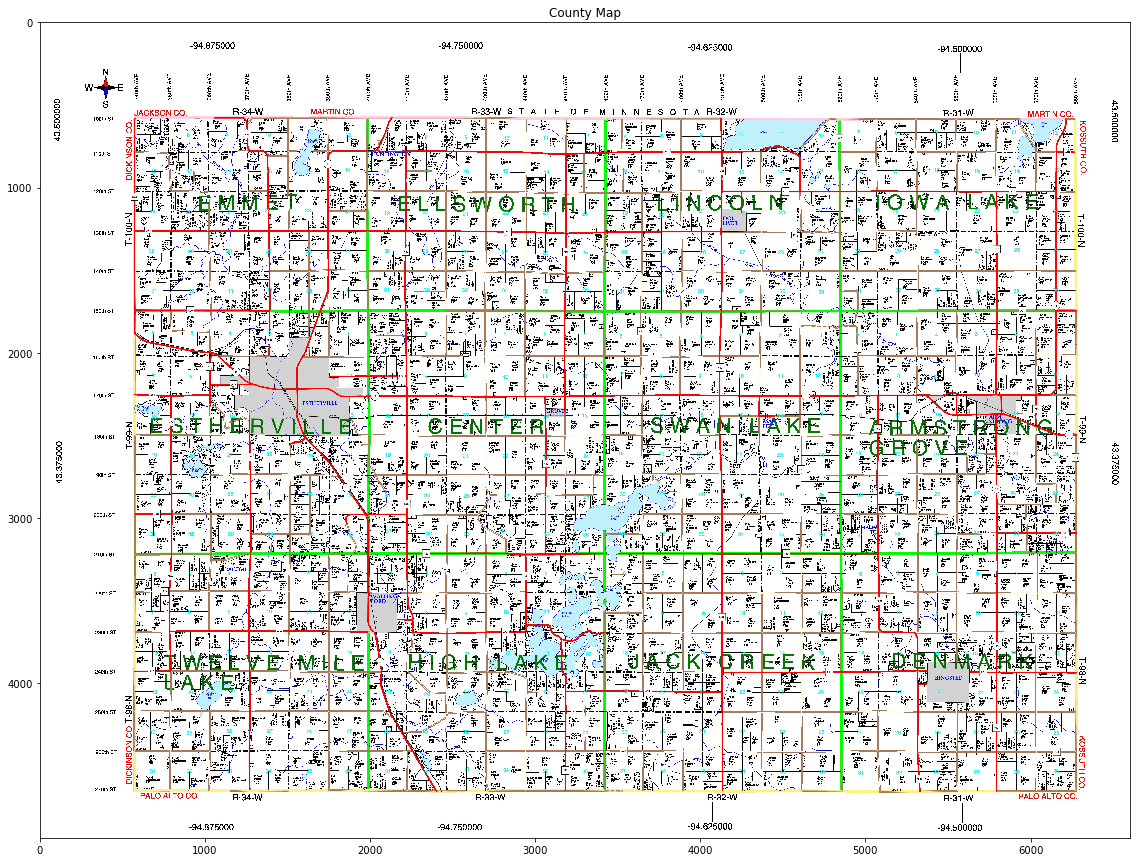

In [2]:
img = cv2.imread('county_map.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, _ = img.shape
plt.imshow(img)
plt.title('County Map')
plt.show()

The map shown above is composed of 12 counties that are delimited by boundaries which can have different colors. In addition, counties contain regions such as lakes, that make the segmentation a bit trickier.

The following code converts the map to HSV space and transforms the pixel values (e.g. normalization) to make them easier to plot. It’s usually better to plot the color data using a script run from the terminal. This allows rotating the 3D plot and facilitates the task of finding value ranges for the target colors. A __color_plot__ script is available in the [twoisprime](https://github.com/twoisprime/twoisprime) package.

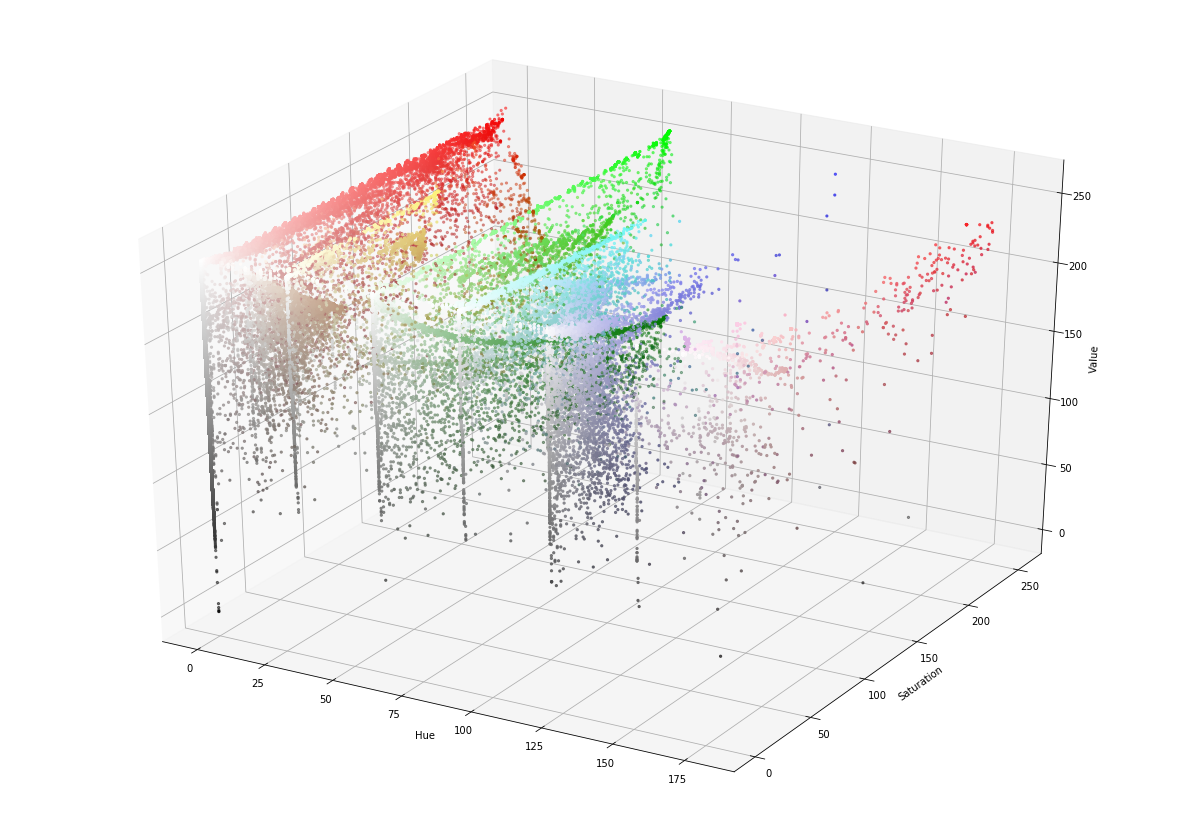

In [3]:
small = cv2.resize(img, (500, 500), interpolation=cv2.INTER_AREA)
pixel_colors = small.reshape((np.shape(small)[0] * np.shape(small)[1], 3))
norm = colors.Normalize(vmin=-1., vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()
hsv = cv2.cvtColor(small, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

As you can see in the plot above, the map is ideal for color segmentation. Colors are isolated and they seem to be easily separable. The next step is to select the relevant colors and find the value ranges. For this we need to inspect the plot, pick an approximate range, and refine it by checking the result. By examining the map we can determine that county boundaries can contain the colors pink, red/brown, yellow, blue/lake, gray, and green. We segment these colors in the next few cells.

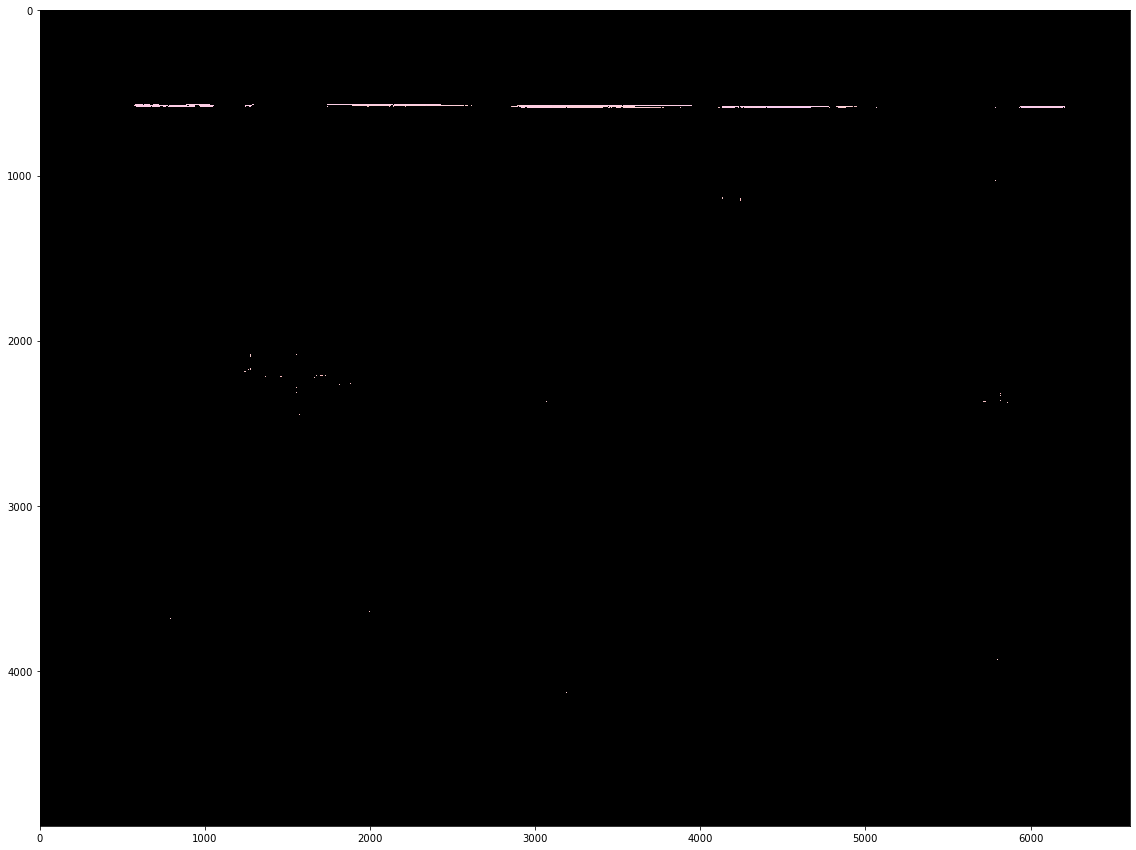

In [4]:
pink_range_min = (150, 45, 200)
pink_range_max = (180, 70, 255)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, pink_range_min, pink_range_max)
pink = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(pink)
plt.show()

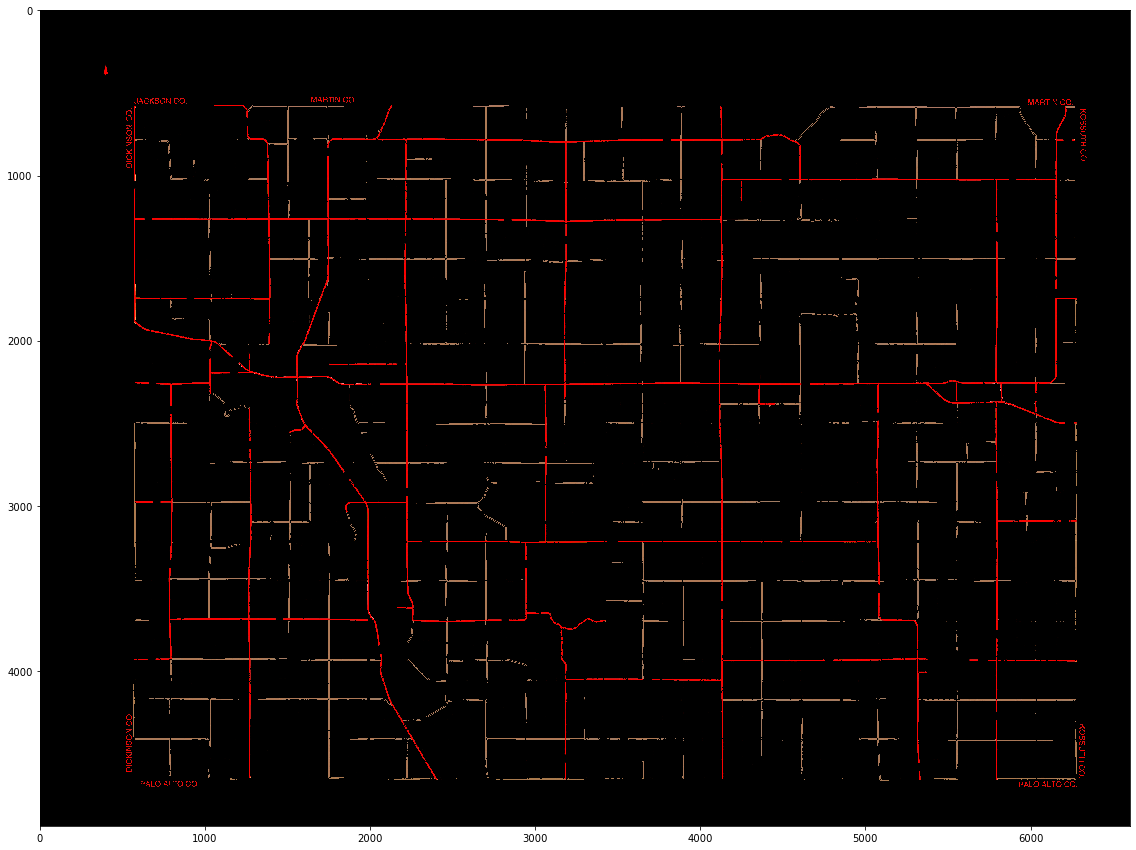

In [5]:
redb_range_min = (0, 100, 0)
redb_range_max = (15, 255, 255)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, redb_range_min, redb_range_max)
redb = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(redb)
plt.show()

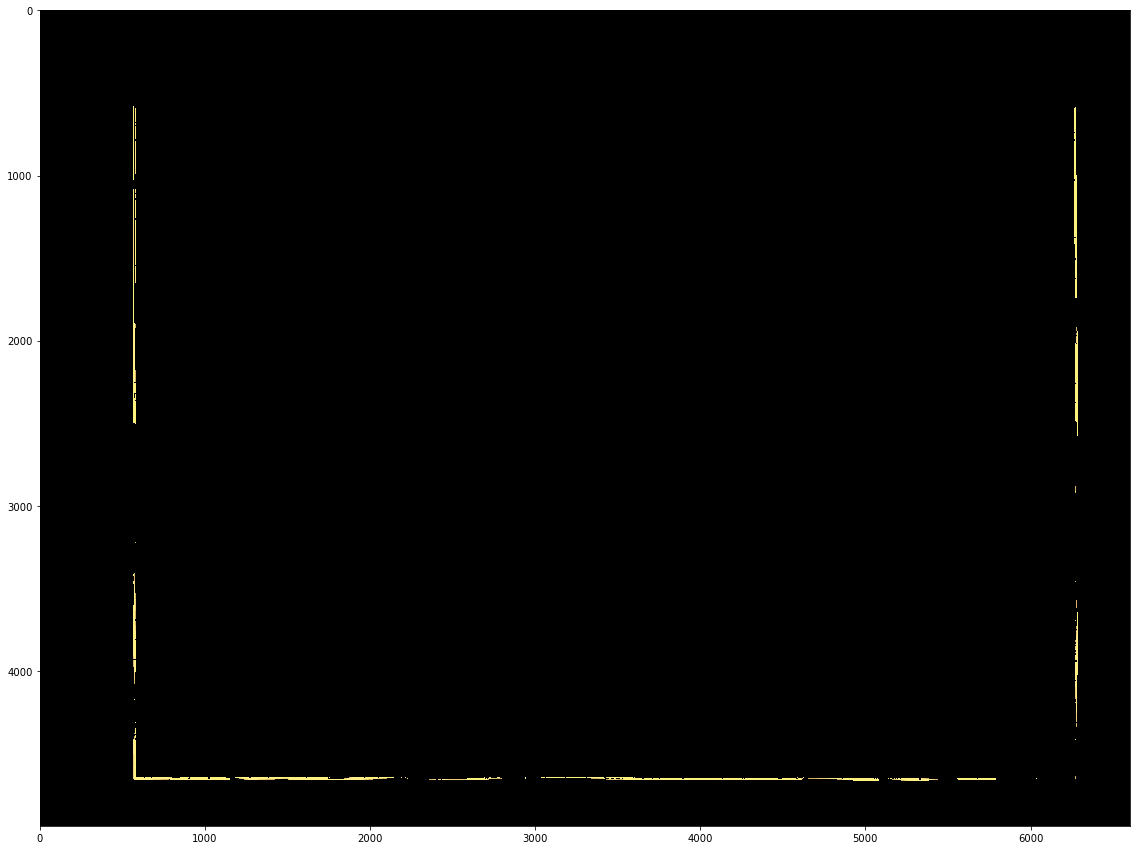

In [6]:
yellow_range_min = (20, 100, 200)
yellow_range_max = (35, 255, 255)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, yellow_range_min, yellow_range_max)
yellow = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(yellow)
plt.show()

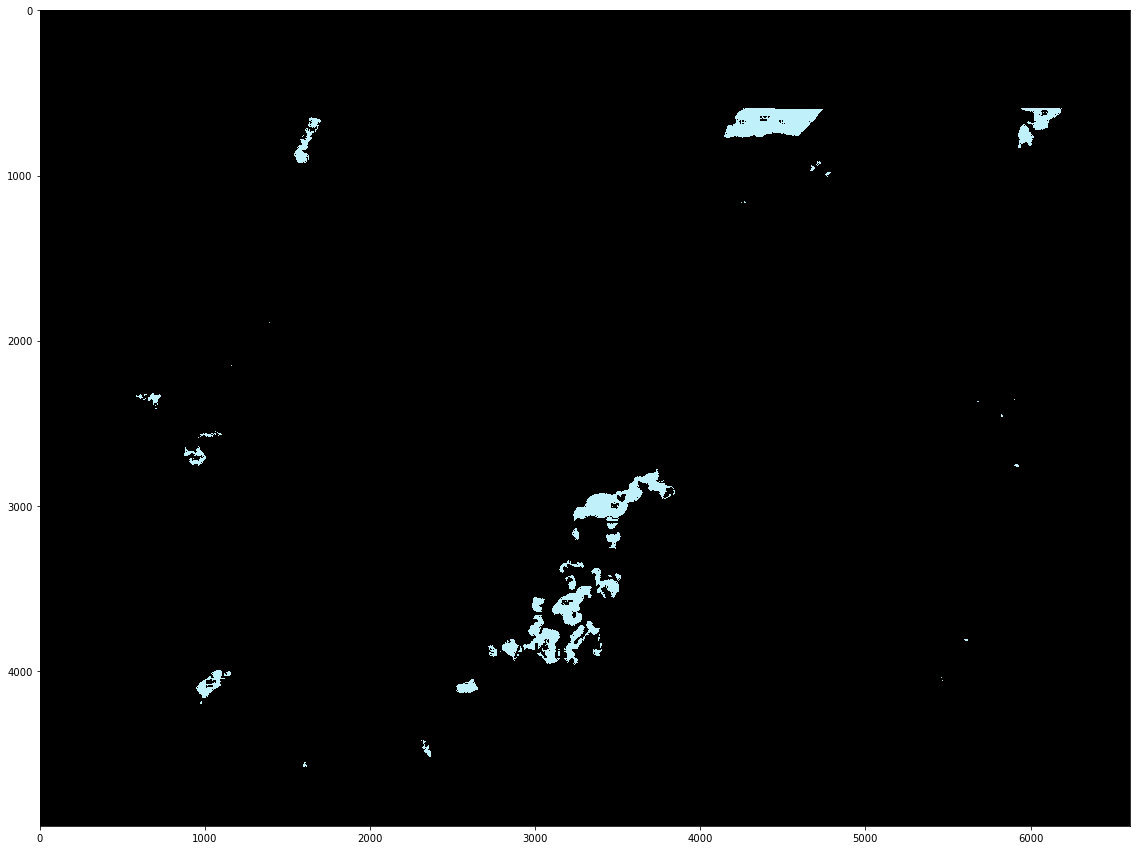

In [7]:
lake_range_min = (80, 40, 200)
lake_range_max = (110, 80, 254)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, lake_range_min, lake_range_max)
lake = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(lake)
plt.show()

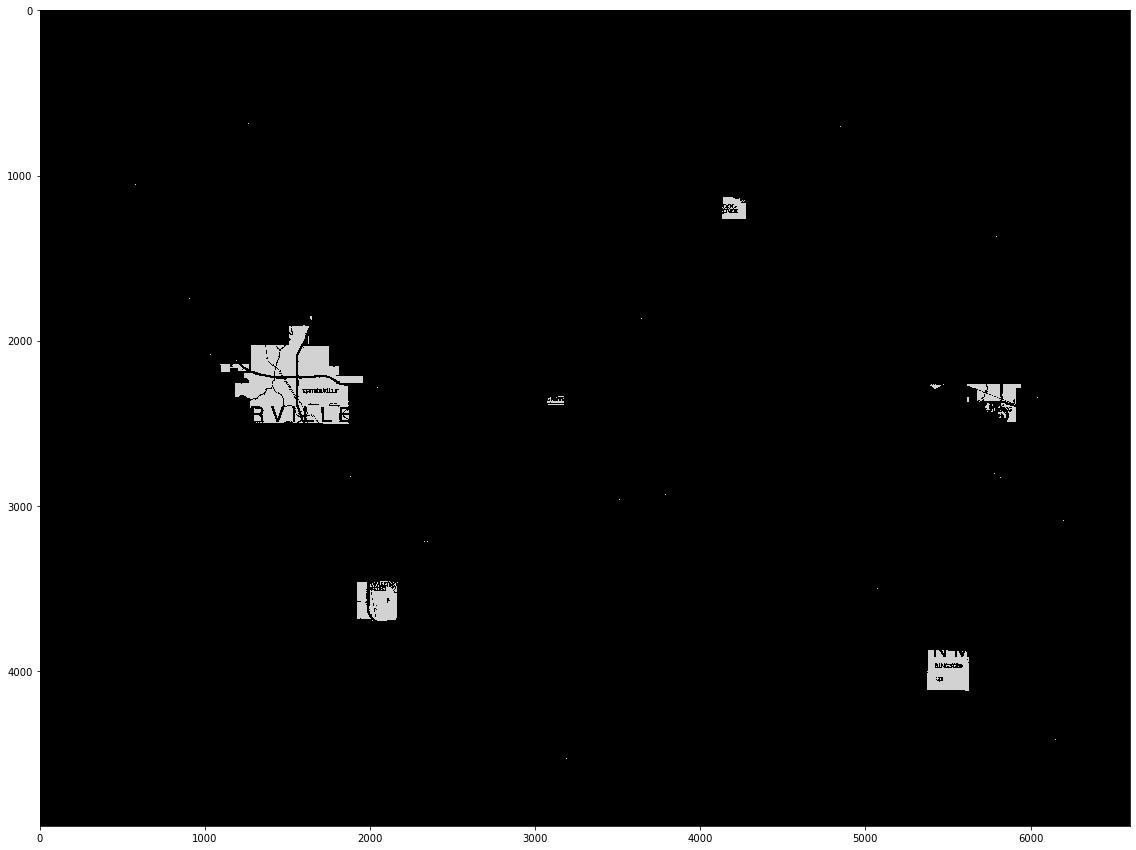

In [8]:
gray_range_min = (0, 0, 200)
gray_range_max = (180, 10, 220)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, gray_range_min, gray_range_max)
gray = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(gray)
plt.show()

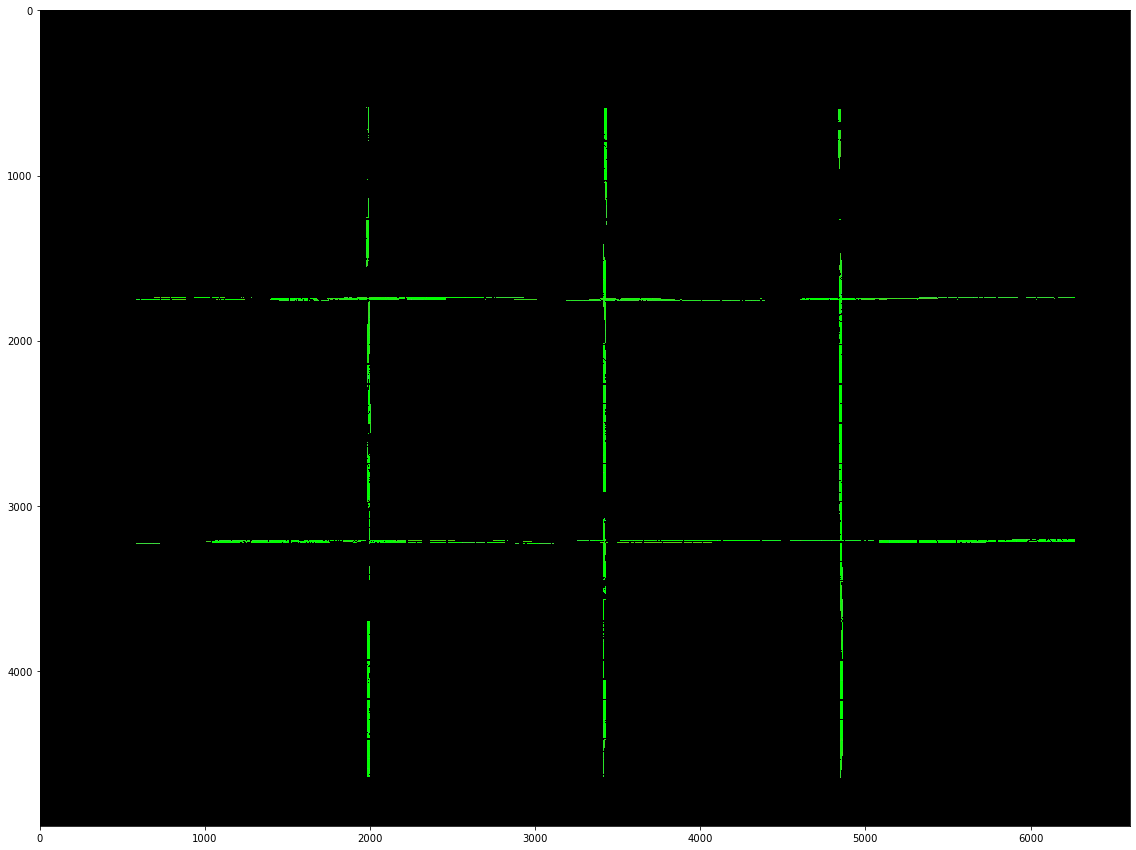

In [9]:
green_range_min = (40, 150, 200)
green_range_max = (75, 255, 255)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, green_range_min, green_range_max)
green = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(green)
plt.show()

Combining all color segmentations and dilating the result produces a mask of the county boundaries. It is important to notice that the red/brown color mix is treated as a secondary layer because it is considered a county border only when it appears together with another color layer. Dilation kernel sizes are chosen in relation to the image width so that they are valid for similar maps which have a different size.

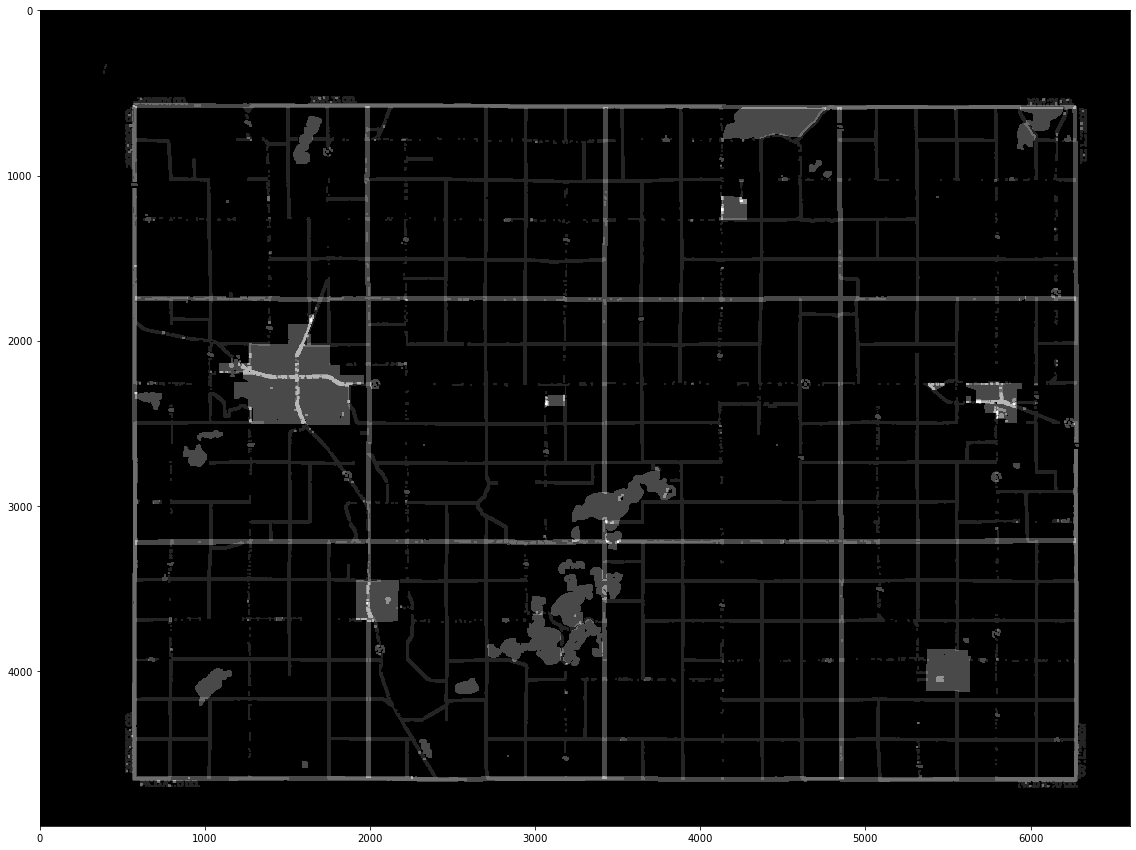

In [10]:
base_layers = [green, yellow, pink, lake, gray]
secondary_layers = [redb]
blend = np.zeros((height, width))
for blayer in base_layers:
    ksz = int(width / (6600/15))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (ksz, ksz))
    dilation = cv2.dilate(blayer, kernel, iterations=1)
    bw = cv2.cvtColor(dilation, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(bw, 0, 128, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    blend += th
for layer in secondary_layers:
    ksz = int(width / (6600/13))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (ksz, ksz))
    dilation = cv2.dilate(layer, kernel, iterations=1)
    bw = cv2.cvtColor(dilation, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(bw, 0, 64, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    blend += th
plt.imshow(blend, cmap='gray')
plt.show()

Thresholding the color layer blend using an intermediate value allows removing the red/brown part which is not part of the county boundaries.

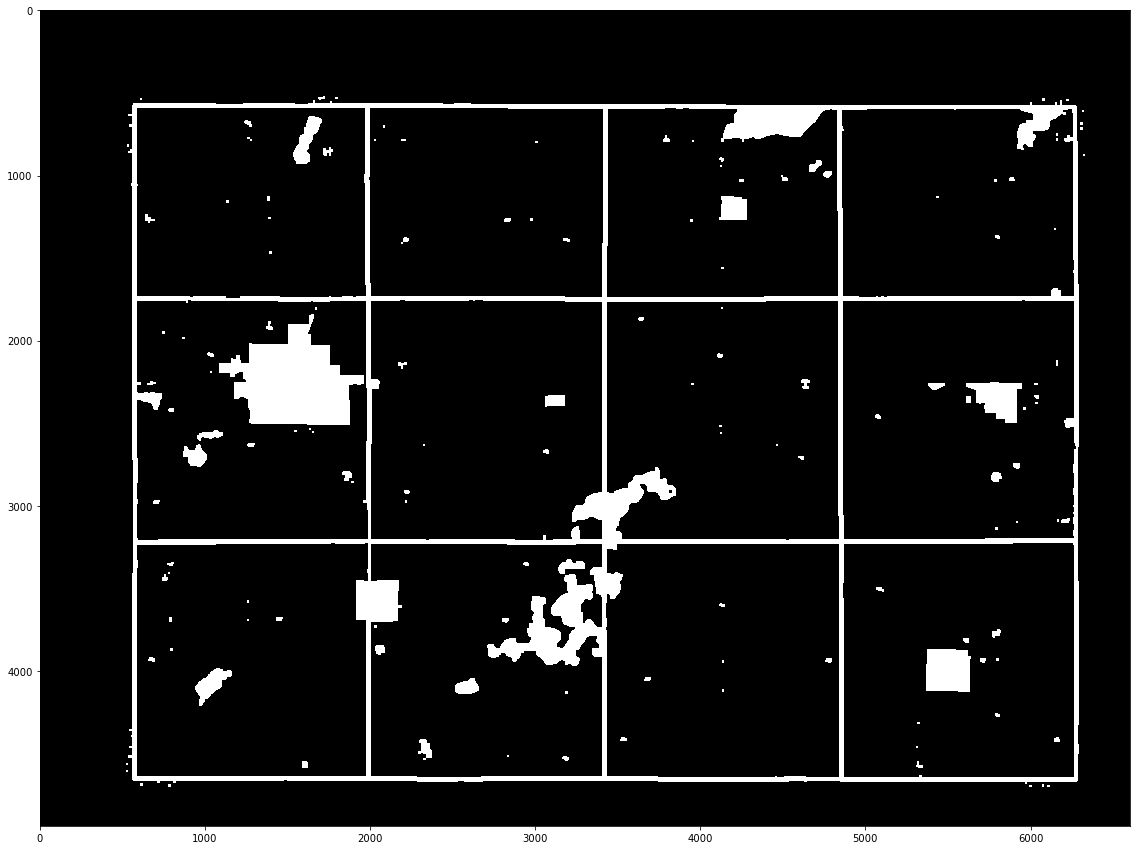

In [11]:
ret, segmentation = cv2.threshold(blend, 100, 255, cv2.THRESH_BINARY)
ksz = int(width / (6600/13))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (ksz, ksz))
segmentation = cv2.dilate(segmentation, kernel, iterations=1)
segmentation = cv2.erode(segmentation, kernel, iterations=1)
plt.imshow(segmentation, cmap='gray')
plt.show()

The final step is to find the contours, filter by area, and display the results. Selecting area values was done again in relation to the width so that we can process similar maps with different sizes.

In [12]:
contours, hierarchy = cv2.findContours(np.array(segmentation, dtype='uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
crop_contours = []
for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    if area < int(width / (6600/10000)) or area > int(width / (6600/10000000)):
        continue
    crop_contours.append(cnt)

152


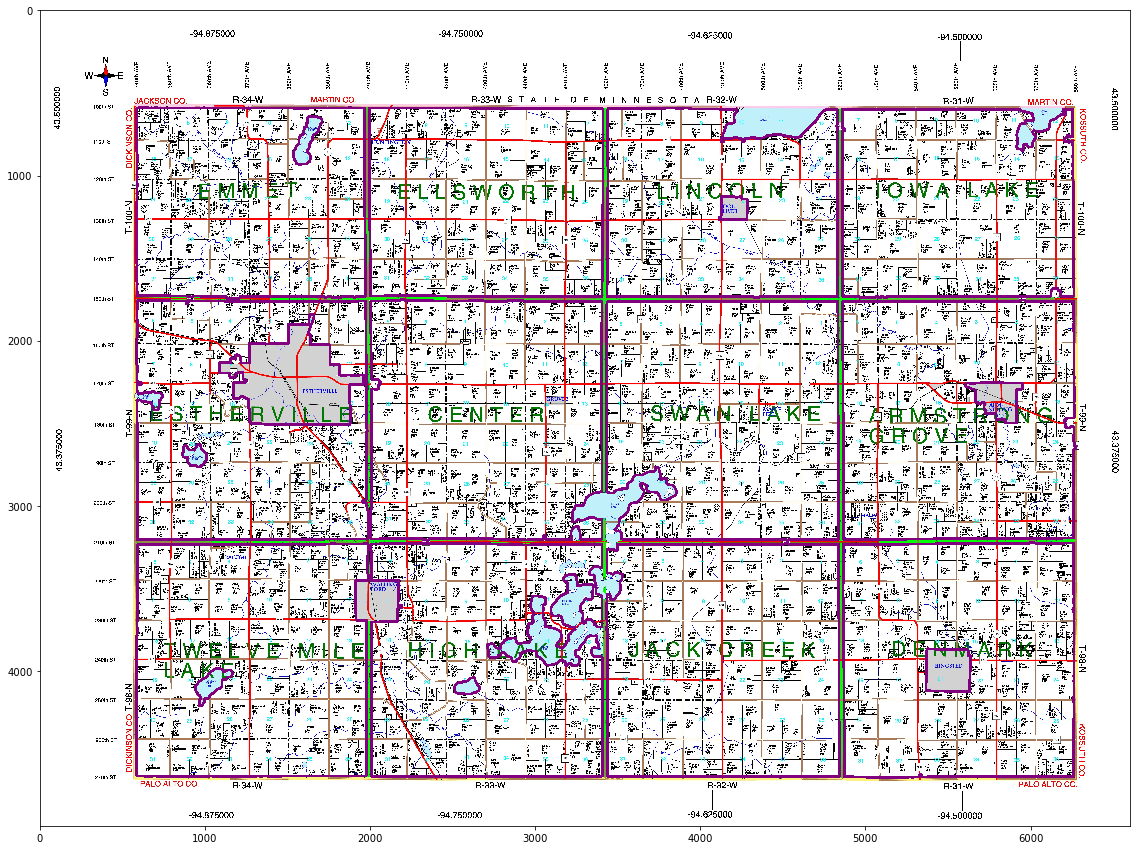

In [13]:
out = np.copy(img)
out = cv2.drawContours(out, crop_contours, -1, (128,0,128), 15)
plt.imshow(out)
plt.show()